<a href="https://colab.research.google.com/github/AmirGhnbr/philnet/blob/main/Philnet_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"a1g3g3a1","key":"590d754de49a1e50ba28dce2922c22fd"}\n'}

In [2]:
!pip install -q kaggle
# !pwd
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d yogesh94/m4-forecasting-competition-dataset
!cp m4-forecasting-competition-dataset.zip ./kaggle
!unzip m4-forecasting-competition-dataset.zip


rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/yogesh94/m4-forecasting-competition-dataset
License(s): CC0-1.0
 84% 67.0M/79.6M [00:00<00:00, 695MB/s]
100% 79.6M/79.6M [00:00<00:00, 706MB/s]
Archive:  m4-forecasting-competition-dataset.zip
  inflating: Daily-test.csv          
  inflating: Daily-train.csv         
  inflating: Hourly-test.csv         
  inflating: Hourly-train.csv        
  inflating: Monthly-test.csv        
  inflating: Monthly-train.csv       
  inflating: Quarterly-test.csv      
  inflating: Quarterly-train.csv     
  inflating: Weekly-test.csv         
  inflating: Weekly-train.csv        
  inflating: Yearly-test.csv         
  inflating: Yearly-train.csv        
  inflating: m4_info.csv             


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import LSTM, Input,add, Dense
from keras.layers import Input, Dense, Dropout, TimeDistributed,LSTM, Concatenate, MultiHeadAttention
import random
from pathlib import Path
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    AveragePooling1D,
    Bidirectional,
    Concatenate,
    Dense,
    GRU,
    Layer,
    LeakyReLU,
)
from tensorflow.keras.metrics import Metric
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

In [4]:
daily = pd.read_csv('Daily-train.csv')
random_number = random.randint(2036, 3594)
values = daily.loc[random_number].dropna().values[1:]
dataset = pd.DataFrame({'num': range(1, len(values) + 1), 'value': values}).dropna().set_index('num')
scaler = MinMaxScaler()

# fit the scaler to the data and transform the data
normalized = scaler.fit_transform(dataset).squeeze()
normalized_dataset = pd.DataFrame({'num': range(1, len(normalized) + 1), 'value': normalized}).dropna().set_index('num')

normalized_dataset

,value
num,
1,1.000000
2,0.989218
3,0.928404
4,0.961526
5,0.993344
...,...
4193,0.387186
4194,0.388909
4195,0.400092


In [34]:
HORIZON = 18 #12
WINDOW_SIZE = 36 #48
BATCH_SIZE = 64

In [35]:
def create_data_window(dataframe):
  X = dataframe.copy()

  windows = pd.DataFrame(columns=[f'window_{i}' for i in range(WINDOW_SIZE)])
  labels = pd.DataFrame(columns=[f'label_{i}' for i in range(HORIZON)])

  # loop through the time series data and create windows and labels
  for i in range(0, len(X) - WINDOW_SIZE - HORIZON + 1, WINDOW_SIZE):
      window = X.iloc[i:i+WINDOW_SIZE]['value'].values
      label = X.iloc[i+WINDOW_SIZE:i+WINDOW_SIZE+HORIZON]['value'].values
      windows.loc[X.index[i+WINDOW_SIZE+HORIZON-1]] = window
      labels.loc[X.index[i+WINDOW_SIZE+HORIZON-1]] = label

  # convert windows and labels back to DataFrames
  windows = pd.DataFrame(windows, columns=[f'window_{i}' for i in range(WINDOW_SIZE)], index=windows.index)
  labels = pd.DataFrame(labels, columns=[f'label_{i}' for i in range(HORIZON)], index=labels.index)
  return windows,labels


create_data_window(normalized_dataset)



(      window_0  window_1  window_2  window_3  window_4  window_5  window_6  \
 54    1.000000  0.989218  0.928404  0.961526  0.993344  0.975353  0.976859   
 90    0.934806  0.929199  0.937152  0.920419  0.912670  0.914539  0.918912   
 126   0.891004  0.896179  0.884634  0.879859  0.896217  0.873782  0.889224   
 162   0.875644  0.827189  0.768314  0.741988  0.733152  0.649902  0.661740   
 198   0.754938  0.748498  0.782224  0.774207  0.816814  0.803196  0.840819   
 ...        ...       ...       ...       ...       ...       ...       ...   
 4050  0.309029  0.309532  0.304032  0.303181  0.306938  0.312202  0.306416   
 4086  0.311712  0.314064  0.316003  0.320816  0.323492  0.324020  0.330148   
 4122  0.349379  0.350892  0.346283  0.343397  0.340256  0.337173  0.334897   
 4158  0.399144  0.394866  0.395057  0.393715  0.397517  0.398038  0.408038   
 4194  0.399761  0.396188  0.393582  0.386678  0.388566  0.381210  0.381592   
 
       window_7  window_8  window_9  ...  window_2

In [36]:
def create_full_datset(windowed_X, windowed_y, batch_size=64):
  # drop_list = ['value' if i==0 else f"value-{i}" for i in range(HORIZON)]
  # X = windowed_dataset.dropna().drop(drop_list, axis=1)
  # y = windowed_dataset.dropna()[drop_list]

  split_size = int(len(windowed_X) * 0.8)
  X_train, y_train = windowed_X[:split_size], windowed_y[:split_size]
  X_test, y_test = windowed_X[split_size:], windowed_y[split_size:]

  X_train = X_train.astype('float32')
  y_train = y_train.astype('float32')
  X_test = X_test.astype('float32')
  y_test = y_test.astype('float32')

  train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
  train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

  test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
  test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

  # 2. Combine features & labels
  train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
  test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

  # 3. Batch and prefetch for optimal performance
  BATCH_SIZE = batch_size # taken from Appendix D in N-BEATS paper
  train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

In [37]:
class MovingAverageSmoothingLayer(tf.keras.layers.Layer):
    def __init__(self, pool_size=3, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.average_pooling_layer = tf.keras.layers.AveragePooling1D(pool_size=(self.pool_size))

    def call(self, inputs):
        inputs = tf.reshape(inputs, shape=(-1, 36, 1))
        return self.average_pooling_layer(inputs)


In [38]:
INPUT_SIZE = WINDOW_SIZE

In [39]:
class WAPE(Metric):
    def __init__(self, name='wape', **kwargs):
        super(WAPE, self).__init__(name=name, **kwargs)
        self.total_abs_error = self.add_weight(name='total_abs_error', initializer='zeros')
        self.total_demand = self.add_weight(name='total_demand', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        abs_error = tf.abs(y_true - y_pred)
        demand = tf.reduce_sum(y_true)
        self.total_abs_error.assign_add(tf.reduce_sum(abs_error))
        self.total_demand.assign_add(demand)

    def result(self):
        return self.total_abs_error / self.total_demand * 100

In [40]:
def philnet_level(input_layer,sigma,prev_hidden_state,is_first_level=False):

  # Moving Average Smoothing
  smoothed_input = MovingAverageSmoothingLayer(sigma)(input_layer)
  # Create the LSTM layer
  # lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation=tf.keras.layers.LeakyReLU(alpha=0.001),return_sequences=True,return_state=True))(smoothed_input)
  lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation="silu", return_sequences=True))(smoothed_input)
  attention = MultiHeadAttention(num_heads=7, key_dim=7)(lstm1, lstm1)
  concat = Concatenate()([lstm1, attention])
  lstm, forward_h, backward_h = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation="silu", return_sequences=True,return_state=True))(concat)

  state_h = Concatenate()([forward_h, backward_h])
  # state_h = add([forward_h, backward_h])
  # lstm_layer, state_h, state_c = LSTM(units=128, return_state=True)(smoothed_input)

  if is_first_level:
    summed_state_h = state_h
  else:
    summed_state_h = add([state_h, prev_hidden_state])

  # as illustrated in table 5 for m4 dataset:
  # uses 2 layers with 64 units and 8 levels
  dense_layer1 = Dense(units=128, activation="silu")(summed_state_h)
  # drop_1 = Dropout(0.1)(dense_layer1)
  dense_layer2 = Dense(units=128, activation="silu")(dense_layer1)
  # drop_2 = Dropout(0.1)(dense_layer2)
  # dropout_1 = tf.keras.layers.Dropout(0.1)(dense_layer1)
  dense_layer3 = Dense(units=128, activation="silu")(dense_layer2)

  # dropout_2 = tf.keras.layers.Dropout(0.1)(dense_layer2)
  # dense_layer4 = Dense(units=128, activation=tf.keras.layers.LeakyReLU(alpha=0.001))(dense_layer3)
  smoothed_output = Dense(units=HORIZON, activation="silu")(dense_layer3)

  return smoothed_output, state_h

In [41]:
def create_model():
  #input_shape = (WINDOW_SIZE,HORIZON)  # Original problematic line
  input_shape = (WINDOW_SIZE,)  # Corrected line for univariate time series
  # Create the input layer
  input_layer = Input(shape=input_shape)

  # According to table 5 the number of levels for m4 dataset is 8
  # As mentions in the last sentence of 2ed paragraph of section 5.3.1 the default
  # value for smoothing factor of 4 is the most common value

  num_levels_from_paper = 8 # Example based on M4 dataset from Table 5 [cite: 285]

  initial_sigma_val = int(INPUT_SIZE)

  # Level 1
  smoothed_output_1, first_hidden_state = philnet_level(input_layer, sigma=initial_sigma_val, prev_hidden_state=None, is_first_level=True)
  prev_hidden_state = first_hidden_state
  all_outputs = [smoothed_output_1] # If you plan to implement the paper's full loss [cite: 145, 146]

  # Loop runs from i=2 up to initial_sigma_val-1.
  # This creates initial_sigma_val - 2 levels.
  for i in range(2, initial_sigma_val):
    current_sigma = initial_sigma_val - i + 1 # Ensures sigma decreases, e.g., 36, 35, ..., 2
    if current_sigma < 1: # Sigma should not be less than 1
        current_sigma = 1
    # The paper specifies concatenating hidden states[cite: 132, 134]. Your `philnet_level` currently uses `add`.
    smoothed_output_level, hidden_state = philnet_level(input_layer, sigma=current_sigma, prev_hidden_state=prev_hidden_state)
    prev_hidden_state = hidden_state # Or concatenate if you change hidden state combination
    all_outputs.append(smoothed_output_level)

  # Final level with sigma=1 [cite: 128]
  final_output, _ = philnet_level(input_layer, sigma=1, prev_hidden_state=prev_hidden_state)
  all_outputs.append(final_output)

  # The paper's loss calculation involves outputs from all levels[cite: 145, 146].
  # For now, the model outputs only the final prediction as in your original code.
  model = tf.keras.Model(inputs=input_layer,
                         outputs=final_output,
                         name="model_Philnet")

  return model

In [42]:
X,y = create_data_window(normalized_dataset)
X

,window_0,window_1,window_2,window_3,window_4,window_5,window_6,window_7,window_8,window_9,...,window_26,window_27,window_28,window_29,window_30,window_31,window_32,window_33,window_34,window_35
54,1.000000,0.989218,0.928404,0.961526,0.993344,0.975353,0.976859,0.946872,0.943077,0.963274,...,0.944933,0.932441,0.957775,0.950654,0.936427,0.934882,0.960591,0.950966,0.942320,0.947578
90,0.934806,0.929199,0.937152,0.920419,0.912670,0.914539,0.918912,0.925607,0.943827,0.953407,...,0.904564,0.907031,0.911303,0.902676,0.884551,0.889287,0.904882,0.893598,0.886471,0.882949
126,0.891004,0.896179,0.884634,0.879859,0.896217,0.873782,0.889224,0.873928,0.855314,0.875034,...,0.921341,0.917781,0.922841,0.916986,0.931010,0.936287,0.906261,0.919453,0.900057,0.906916
162,0.875644,0.827189,0.768314,0.741988,0.733152,0.649902,0.661740,0.629832,0.562966,0.539164,...,0.738911,0.741060,0.741270,0.716559,0.741607,0.739267,0.776775,0.774074,0.801372,0.771359
198,0.754938,0.748498,0.782224,0.774207,0.816814,0.803196,0.840819,0.862510,0.839192,0.818505,...,0.825282,0.822465,0.805371,0.799090,0.788460,0.772065,0.758168,0.790361,0.781855,0.775059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4050,0.309029,0.309532,0.304032,0.303181,0.306938,0.312202,0.306416,0.310491,0.313486,0.312806,...,0.311127,0.318597,0.312138,0.317370,0.312373,0.311960,0.312240,0.311293,0.306245,0.309837
4086,0.311712,0.314064,0.316003,0.320816,0.323492,0.324020,0.330148,0.326684,0.318254,0.320066,...,0.338839,0.344719,0.343594,0.348864,0.355514,0.352056,0.347364,0.350517,0.346073,0.351846
4122,0.349379,0.350892,0.346283,0.343397,0.340256,0.337173,0.334897,0.334897,0.337440,0.339468,...,0.399723,0.404497,0.409545,0.411916,0.401528,0.395832,0.400041,0.403175,0.402832,0.398992
4158,0.399144,0.394866,0.395057,0.393715,0.397517,0.398038,0.408038,0.405394,0.397275,0.398877,...,0.383696,0.393944,0.390829,0.396392,0.400015,0.398731,0.401096,0.404472,0.404008,0.404084


In [43]:
tf.random.set_seed(42)
X,y = create_data_window(normalized_dataset)
# windowed_data= create_data_window(normalized_dataset)
train_dataset, test_dataset = create_full_datset(X,y)
model = create_model()

# There is no data available on the optimizer, trainded loss function and number of epochs
# so i use classic adam optimizer, mae loss and 300 epochs
model.compile(loss='huber',
            optimizer=tf.keras.optimizers.Nadam(),
            metrics=["mae", WAPE(),'mse','mape'])


history = model.fit(train_dataset,
        epochs=400,
        validation_data=test_dataset,
        verbose=1, # prevent large amounts of training outputs

        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor="val_mape", patience=100, restore_best_weights=True),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mape", patience=25, verbose=1)]
          )


Epoch 1/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.1020 - mae: 0.3933 - mape: 678.5977 - mse: 0.2040 - wape: 99.7236 - val_loss: 0.0499 - val_mae: 0.3120 - val_mape: 97.9323 - val_mse: 0.0998 - val_wape: 97.9715 - learning_rate: 0.0010
Epoch 2/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0991 - mae: 0.3864 - mape: 1792.3226 - mse: 0.1982 - wape: 97.9457 - val_loss: 0.0469 - val_mae: 0.3023 - val_mape: 94.8046 - val_mse: 0.0937 - val_wape: 94.9015 - learning_rate: 0.0010
Epoch 3/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0944 - mae: 0.3747 - mape: 4153.2734 - mse: 0.1887 - wape: 94.9479 - val_loss: 0.0406 - val_mae: 0.2809 - val_mape: 87.9667 - val_mse: 0.0812 - val_wape: 88.1841 - learning_rate: 0.0010
Epoch 4/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0843 - mae: 0.3486 - mape: 9905.7490 - mse: 0.1685 - wape: 88.2705 - val_loss: 0.0276 - val_mae: 0.2296 - val_mape: 71.5817 - val_mse: 0.0552 - val_wape: 72.0743 - learning_rate: 0.0010
Epoch 5/400
2/2

In [44]:
evaluation = model.evaluate(test_dataset)
evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.8134e-04 - mae: 0.0178 - mape: 5.7467 - mse: 5.6267e-04 - wape: 5.5996


[0.00028133660089224577,
 0.01783481054008007,
 5.599606990814209,
 0.0005626732017844915,
 5.746744155883789]

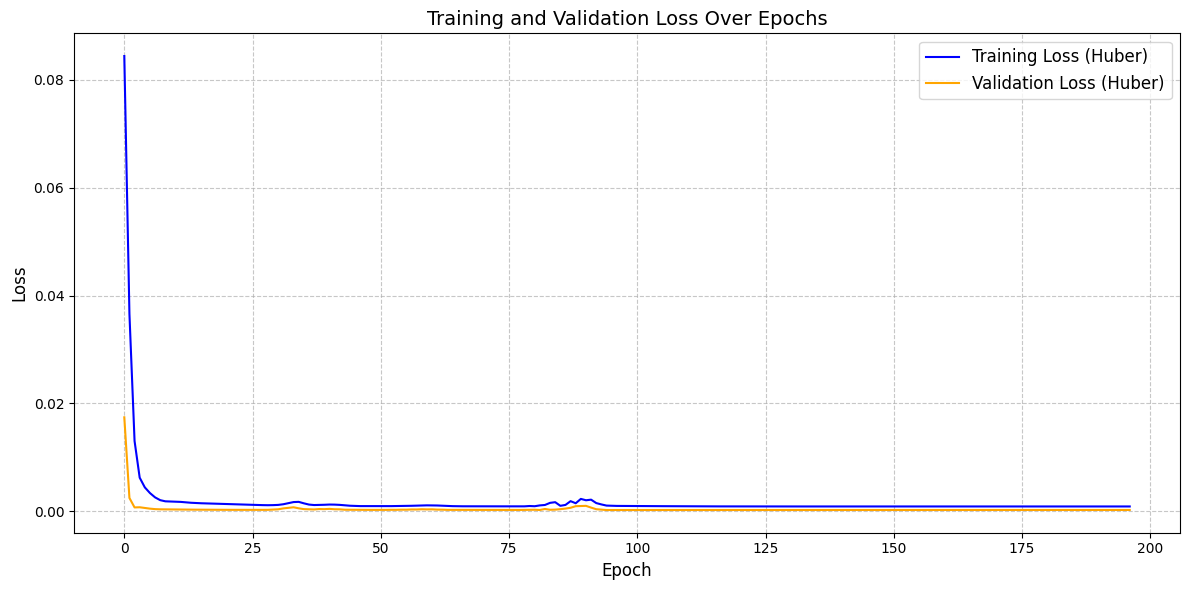

In [22]:
import matplotlib.pyplot as plt # Corrected import statement

# Assuming 'history' is a Keras History object from model.fit()
# and contains 'loss' and 'val_loss' keys.

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss (Huber)', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss (Huber)', color='orange')
plt.title('Training and Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
model.summary()

Model: "model_Philnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ moving_average_smo… │ (None, 36, 1)     │          0 │ input_layer_1[0]… │
│ (MovingAverageSmoo… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ moving_average_smo… │ (None, 18, 1)     │          0 │ input_layer_1[0]… │
│ (MovingAverageSmoo… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_70    │ (None, 36, 128)   │     25,728 │ moving_average_s… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_68    │ (None, 18, 128)   │     25,728 │ moving_average_s… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 36, 128)   │     25,363 │ bidirectional_70… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_70… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 18, 128)   │     25,363 │ bidirectional_68… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_68… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_70      │ (None, 36, 256)   │          0 │ bidirectional_70… │
│ (Concatenate)       │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_68      │ (None, 18, 256)   │          0 │ bidirectional_68… │
│ (Concatenate)       │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_71    │ [(None, 36, 128), │    123,648 │ concatenate_70[0… │
│ (Bidirectional)     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_69    │ [(None, 18, 128), │    123,648 │ concatenate_68[0… │
│ (Bidirectional)     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_71      │ (None, 128)       │          0 │ bidirectional_71… │
│ (Concatenate)       │                   │            │ bidirectional_71… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_69      │ (None, 128)       │          0 │ bidirectional_69… │
│ (Concatenate)       │                   │            │ bidirectional_69… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 128)       │          0 │ concatenate_71[0… │
│                     │                   │            │ concatenate_69[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 128)       │     16,512 │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_141 (Dense)   │ (None, 128)       │     16,512 │ dense_140[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_142 (Dense)   │ (None, 128)       │     16,512 │ dense_141[0][0] 

 Total params: 1,204,011 (4.59 MB)

 Trainable params: 401,336 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 802,675 (3.06 MB)

## plot

In [24]:
!pip install python-ternary -q

/usr/local/lib/python3.11/dist-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


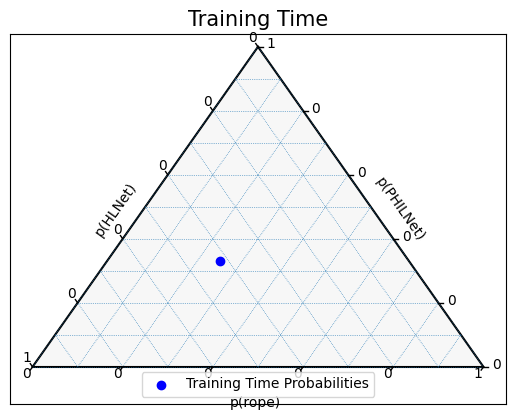

In [25]:
import ternary
import matplotlib.pyplot as plt

# Triangle coordinates: (HLNet, PHILNet, rope)
# Fig. 2 (a) - Training Time
data_training = [(0.25, 0.33, 0.42)]  # p(HLNet)=1.0, p(PHILNet)=0.0, p(rope)=0.0

# Fig. 2 (b) - WAPE
data_wape = [(0.25, 0.33, 0.42)]  # p(rope)=1.0

# Ternary plot settings
figure, tax = ternary.figure(scale=1.0)
tax.boundary()
tax.gridlines(multiple=0.1)
tax.set_title("Training Time", fontsize=15)
tax.scatter(data_training, marker='o', color='blue', label="Training Time Probabilities")
tax.left_axis_label("p(HLNet)")
tax.right_axis_label("p(PHILNet)")
tax.bottom_axis_label("p(rope)")
tax.ticks(axis='lbr', multiple=0.2, linewidth=1)
tax.legend()
tax.clear_matplotlib_ticks()
plt.show()


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ternary_manual(prob_array, title="Posterior probabilities"):
    """
    Matplotlib-only ternary scatter.  prob_array is (n,3) with rows summing to 1.
    """
    # barycentric to Cartesian
    def bc2xy(pA, pR, pB):
        # vertices: A=(0,0), R=(0.5,√3/2), B=(1,0)
        x = 0.5*(2*pB + pR)
        y = (np.sqrt(3)/2)*pR
        return x, y

    fig, ax = plt.subplots(figsize=(4,4))
    tri = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2],[0,0]])
    ax.plot(tri[:,0], tri[:,1], color='orange')
    ax.set_xlim(-0.05,1.05); ax.set_ylim(-0.05,0.9)
    ax.set_xticks([]); ax.set_yticks([])

    for pA, pR, pB in prob_array:
        x, y = bc2xy(pA, pR, pB)
        ax.scatter(x, y, s=25)

    ax.text(0, -0.05,   "p(HLNet)", ha='center')
    ax.text(1, -0.05,   "p(PHILNet)", ha='center')
    ax.text(0.5, 0.89,  "p(rope)", ha='center')
    ax.set_title(title, pad=20)
    plt.tight_layout()
    return fig



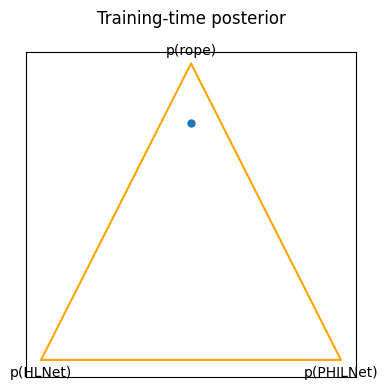

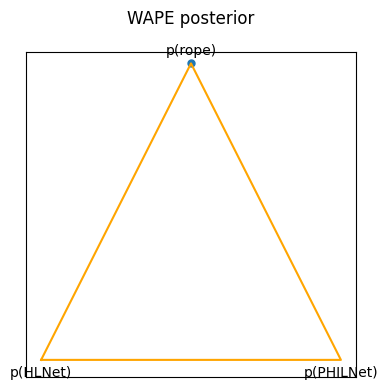

In [27]:
# Example posterior data
posteriors_time = np.array([[0.1, 0.8, 0.1]])   # HLNet always better
posteriors_wape = np.array([[0.0, 1.0, 0.0]])   # 100% rope

# Plot
plot_ternary_manual(posteriors_time, "Training-time posterior")
plot_ternary_manual(posteriors_wape, "WAPE posterior")
plt.show()


## improved version

In [30]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Layer, Concatenate,
                                     Add, LayerNormalization, Activation, GlobalAveragePooling1D)
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Metric
import random
import matplotlib.pyplot as plt

# --- 1. بارگذاری و پیش‌پردازش داده‌ها ---
try:
    daily = pd.read_csv('Daily-train.csv')
    random_number = random.randint(0, len(daily) - 1)
    values = daily.loc[random_number].dropna().values[1:]
except FileNotFoundError:
    print("فایل Daily-train.csv یافت نشد. از مجموعه داده مصنوعی استفاده می‌شود.")
    values = np.sin(np.linspace(0, 400, 2000)) + np.random.randn(2000) * 0.2 + np.linspace(0, 5, 2000)

# اطمینان از خالی نبودن داده‌ها
if values.size == 0:
    print("هشدار: داده‌های بارگذاری شده خالی است. از یک مجموعه داده مصنوعی حداقلی استفاده می‌شود.")
    values = np.random.rand(200)

dataset = pd.DataFrame({'value': values}).dropna()
if dataset.empty:
     dataset = pd.DataFrame({'value': np.random.rand(200)})

scaler = MinMaxScaler()
dataset['value'] = scaler.fit_transform(dataset[['value']])

# --- 2. ایجاد مجموعه داده پنجره‌ای ---
HORIZON = 18
WINDOW_SIZE = 72
BATCH_SIZE = 64

def create_data_window(data: np.ndarray, window_size: int, horizon: int):
    """ایجاد پنجره‌ها و برچسب‌ها از یک آرایه نامپای."""
    if len(data) < window_size + horizon:
        print(f"هشدار: داده کافی برای ایجاد پنجره وجود ندارد (طول داده: {len(data)})")
        return np.empty((0, window_size)), np.empty((0, horizon))

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[(i + window_size):(i + window_size + horizon)])
    return np.array(X), np.array(y)

def create_tf_dataset(X, y, batch_size=64):
    """ایجاد یک مجموعه داده TensorFlow دسته‌بندی شده."""
    if X.shape[0] == 0:
        return tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size), \
               tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size)

    dataset_tf = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), y.astype(np.float32)))
    split_size = int(X.shape[0] * 0.8)
    train_ds = dataset_tf.take(split_size).shuffle(buffer_size=split_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = dataset_tf.skip(split_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_ds, test_ds

X_data, y_data = create_data_window(dataset['value'].values, WINDOW_SIZE, HORIZON)
train_dataset, test_dataset = create_tf_dataset(X_data, y_data, BATCH_SIZE)

# --- 3. لایه‌ها و معیارهای سفارشی ---

class RevIN(Layer):
    """لایه نرمال‌سازی نمونه معکوس‌پذیر (Reversible Instance Normalization)"""
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.mean = None
        self.stdev = None

    def call(self, x, mode):
        if mode == 'normalize':
            self.mean = tf.math.reduce_mean(x, axis=-1, keepdims=True)
            self.stdev = tf.math.sqrt(tf.math.reduce_variance(x, axis=-1, keepdims=True) + self.epsilon)
            return (x - self.mean) / self.stdev
        elif mode == 'denormalize':
            if self.mean is None or self.stdev is None:
                raise ValueError("ابتدا باید با مد 'normalize' فراخوانی شود.")
            return (x * self.stdev) + self.mean
        else:
            raise ValueError("مد باید 'normalize' یا 'denormalize' باشد.")

class MambaBlock(Layer):
    """پیاده‌سازی پایدارتر بلوک Mamba با استفاده از حلقه for"""
    def __init__(self, d_model, d_state, d_conv=4, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv

        self.in_proj = Dense(2 * d_model, use_bias=False)
        self.conv1d = tf.keras.layers.Conv1D(filters=d_model, kernel_size=d_conv, padding='causal', activation='silu')
        self.dt_proj = Dense(d_model, use_bias=True)
        self.out_proj = Dense(d_model)

    def build(self, input_shape):
        super().build(input_shape)
        # تعریف وزن‌ها در build
        self.A_log = self.add_weight(shape=(self.d_model, self.d_state), name="A_log", initializer="glorot_uniform")
        self.D = self.add_weight(shape=(self.d_model,), name="D", initializer="zeros")
        self.C = self.add_weight(shape=(self.d_model, self.d_state), name="C", initializer="glorot_uniform")
        # **اصلاح کلیدی در اینجا**: شکل ماتریس باید ورودی (d_model) را به خروجی (d_state) نگاشت کند
        self.B_proj_weights = self.add_weight(shape=(self.d_model, self.d_state), name="B_proj_weights", initializer="glorot_uniform")

    def call(self, x):
        batch_size, seq_len, _ = tf.unstack(tf.shape(x))

        x_proj = self.in_proj(x)
        x_conv, x_ssm = tf.split(x_proj, num_or_size_splits=2, axis=-1)
        x_conv = self.conv1d(x_conv)

        # محاسبه پارامتر B از x_conv
        B = tf.einsum('bld,ds->bls', x_conv, self.B_proj_weights)

        dt = tf.nn.softplus(self.dt_proj(x_conv))
        A = -tf.exp(self.A_log)

        # پیش‌محاسبه دلتاها
        deltaA = tf.exp(tf.einsum('bld,dn->bln', dt, A))
        deltaB = tf.einsum('bld,bls->blds', dt, B)

        h = tf.zeros((batch_size, self.d_model, self.d_state), dtype=x.dtype)
        outputs = []

        # حلقه اسکن بازنویسی شده
        for t in range(seq_len):
            u_t = x_ssm[:, t, :]
            h = deltaA[:, t] * h + tf.einsum('bds,bd->bds', deltaB[:, t], u_t)
            y_t = tf.einsum('bds,ds->bd', h, self.C)
            outputs.append(y_t)

        y = tf.stack(outputs, axis=1)
        y = y + x_ssm * self.D # اتصال باقی‌مانده صحیح

        return self.out_proj(y), h

class MovingAverageSmoothingLayer(Layer):
    def __init__(self, pool_size, padding='valid', **kwargs):
        super().__init__(**kwargs)
        self.average_pooling_layer = tf.keras.layers.AveragePooling1D(pool_size=pool_size, strides=1, padding=padding)

    def call(self, inputs):
        return self.average_pooling_layer(inputs)

class WAPE(Metric):
    def __init__(self, name='wape', **kwargs):
        super(WAPE, self).__init__(name=name, **kwargs)
        self.total_abs_error = self.add_weight(name='total_abs_error', initializer='zeros')
        self.total_demand = self.add_weight(name='total_demand', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.total_abs_error.assign_add(tf.reduce_sum(tf.abs(y_true - y_pred)))
        self.total_demand.assign_add(tf.reduce_sum(y_true))

    def result(self):
        return tf.math.divide_no_nan(self.total_abs_error, self.total_demand) * 100
    def reset_state(self):
        self.total_abs_error.assign(0.0)
        self.total_demand.assign(0.0)

# --- 4. مدل PHILNetV2 اصلاح‌شده ---
class PHILNetV2(Model):
    def __init__(self, sigmas, horizon, d_model, d_state, **kwargs):
        super().__init__(**kwargs)
        self.sigmas = sigmas
        self.horizon = horizon
        self.d_model = d_model

        self.revin_layer = RevIN()
        self.smoothing_layers = [MovingAverageSmoothingLayer(s) for s in sigmas]
        self.mamba_blocks = [MambaBlock(d_model, d_state) for _ in sigmas]

        self.dense_blocks = []
        for i in range(len(sigmas)):
            self.dense_blocks.append([
                Dense(d_model * 2, activation='gelu', name=f'ff1_level_{i}'),
                Dense(d_model, name=f'ff2_level_{i}'),
            ])

        self.output_layers = [Dense(horizon) for _ in sigmas]
        self.label_smoothers = [MovingAverageSmoothingLayer(s, padding='same') for s in sigmas]

        self.loss_weights = tf.Variable(tf.ones(len(sigmas)), trainable=True, name="loss_weights")
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.wape_metric = WAPE(name="wape")

    def call(self, inputs, training=None):
        x_norm = self.revin_layer(inputs, mode='normalize')
        x_norm_expanded = tf.expand_dims(x_norm, axis=-1)

        all_outputs_norm = []
        hidden_states_history = []

        for i in range(len(self.sigmas)):
            smoothed_input = self.smoothing_layers[i](x_norm_expanded)
            mamba_out, last_h = self.mamba_blocks[i](smoothed_input)

            # فشرده‌سازی حالت پنهان برای انتقال به سطح بعد
            hidden_repr = GlobalAveragePooling1D()(last_h)

            ff_input = hidden_repr
            if i > 0 and hidden_states_history:
                ff_input = Concatenate()([hidden_repr] + hidden_states_history)

            hidden_states_history.append(hidden_repr)

            # بلوک FeedForward
            x = ff_input
            for layer in self.dense_blocks[i]:
                x = layer(x)

            level_output_norm = self.output_layers[i](x)
            all_outputs_norm.append(level_output_norm)

        final_output_denorm = self.revin_layer(all_outputs_norm[-1], mode='denormalize')
        return all_outputs_norm, final_output_denorm

    @property
    def metrics(self):
        return [self.loss_tracker, self.wape_metric]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            y_pred_list_norm, y_pred_final_denorm = self(x, training=True)

            weights = tf.nn.softmax(self.loss_weights)
            total_loss = 0.0
            y_true_norm = self.revin_layer(y_true, mode='normalize')
            y_true_norm_expanded = tf.expand_dims(y_true_norm, axis=-1)

            for i in range(len(self.sigmas)):
                y_true_smoothed_3d = self.label_smoothers[i](y_true_norm_expanded)
                y_true_smoothed_norm = tf.squeeze(y_true_smoothed_3d, axis=-1)
                level_loss = self.compiled_loss(y_true_smoothed_norm, y_pred_list_norm[i])
                total_loss += weights[i] * level_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.wape_metric.update_state(y_true, y_pred_final_denorm)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y_true = data
        y_pred_list_norm, y_pred_final_denorm = self(x, training=False)

        weights = tf.nn.softmax(self.loss_weights)
        total_loss = 0.0
        y_true_norm = self.revin_layer(y_true, mode='normalize')
        y_true_norm_expanded = tf.expand_dims(y_true_norm, axis=-1)

        for i in range(len(self.sigmas)):
            y_true_smoothed_3d = self.label_smoothers[i](y_true_norm_expanded)
            y_true_smoothed_norm = tf.squeeze(y_true_smoothed_3d, axis=-1)
            level_loss = self.compiled_loss(y_true_smoothed_norm, y_pred_list_norm[i])
            total_loss += weights[i] * level_loss

        self.loss_tracker.update_state(total_loss)
        self.wape_metric.update_state(y_true, y_pred_final_denorm)
        return {m.name: m.result() for m in self.metrics}

# --- 5. آموزش و ارزیابی مدل ---
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

SIGMAS = [16, 8, 4, 1]
D_MODEL = 64
D_STATE = 16

if tf.data.experimental.cardinality(train_dataset).numpy() == 0:
    print("مجموعه داده آموزش خالی است. امکان آموزش مدل وجود ندارد.")
else:
    model = PHILNetV2(sigmas=SIGMAS, horizon=HORIZON, d_model=D_MODEL, d_state=D_STATE)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3), loss=tf.keras.losses.Huber())

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_wape", patience=20, mode='min', restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10, verbose=1)
    ]

    print("شروع آموزش مدل...")
    history = model.fit(train_dataset,
                        epochs=100,
                        validation_data=test_dataset,
                        verbose=1,
                        callbacks=callbacks)

    # --- 6. مصورسازی نتایج ---
    if tf.data.experimental.cardinality(test_dataset).numpy() > 0:
        _, y_pred_final = model.predict(test_dataset)
        y_true_final = np.concatenate([y for _, y in test_dataset], axis=0)

        print("\n--- ارزیابی نهایی مدل روی مجموعه داده آزمون ---")
        final_wape = WAPE()
        final_wape.update_state(y_true_final, y_pred_final)
        print(f"WAPE نهایی: {final_wape.result().numpy():.2f}%")
        print(f"وزن‌های نهایی تابع هزینه (پس از Softmax): {tf.nn.softmax(model.loss_weights).numpy()}")

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='هزینه آموزش')
        plt.plot(history.history['val_loss'], label='هزینه اعتبارسنجی')
        plt.title('نمودار هزینه آموزش و اعتبارسنجی PHILNet 2.0')
        plt.xlabel('اپوک')
        plt.ylabel('هزینه (مجموع وزن‌دار Huber)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        plt.figure(figsize=(15, 7))
        sample_idx = random.randint(0, len(y_true_final) - 1)
        plt.plot(range(HORIZON), y_true_final[sample_idx], 'o-', label='مقادیر واقعی آینده')
        plt.plot(range(HORIZON), y_pred_final[sample_idx], 'x-', label='مقادیر پیش‌بینی شده آینده')
        plt.title(f'مقایسه نمونه پیش‌بینی (نمونه {sample_idx}) با مقادیر واقعی')
        plt.xlabel('افق زمانی')
        plt.ylabel('مقدار')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("مجموعه داده آزمون خالی است. ارزیابی و مصورسازی انجام نشد.")

شروع آموزش مدل...
Epoch 1/100


TypeError: Exception encountered when calling MambaBlock.call().

[1m'SymbolicTensor' object cannot be interpreted as an integer[0m

Arguments received by MambaBlock.call():
  • x=tf.Tensor(shape=(None, 57, 1), dtype=float32)